In [1]:
# 라이브러리 불러오기 
import numpy as np # 수치계산용 라이브러리
import pandas as pd # 표를 다룰때 사용
import matplotlib.pyplot as plt # 그래프(시각화) 라이브러리
import seaborn as sns # 시각화 라이브러리
# 머신러닝 라이브러리 

# 데이터 분리도구 
from sklearn.model_selection import train_test_split

# 교차검증도구 


from sklearn.model_selection import cross_val_score # 분류용 모델 평가도구 (정확도)

## 목표
 - 타이타닉데이터를 활용해서 생존자 분류 예측(2~3일)
 - 전처리과정, EDA확인
 - kaggle 경진대회에서 높은 점수 달성

### 1. 문제정의
- 타이타닉데이터를 통하여 생존자 예측
- 분류 실습 (살았다, 죽었다) 이진분류 실습
- 전처리

### 2. 데이터 수집
- kaggle에서 train, test 데이터 다운로드

In [2]:
# 데이터 불러오기 
train_data = pd.read_csv('data/train.csv', index_col = 'PassengerId')
test_data = pd.read_csv('data/test.csv', index_col = 'PassengerId')

In [3]:
print(train_data.shape, test_data.shape)

(891, 11) (418, 10)


In [4]:
train_data.shape

(891, 11)

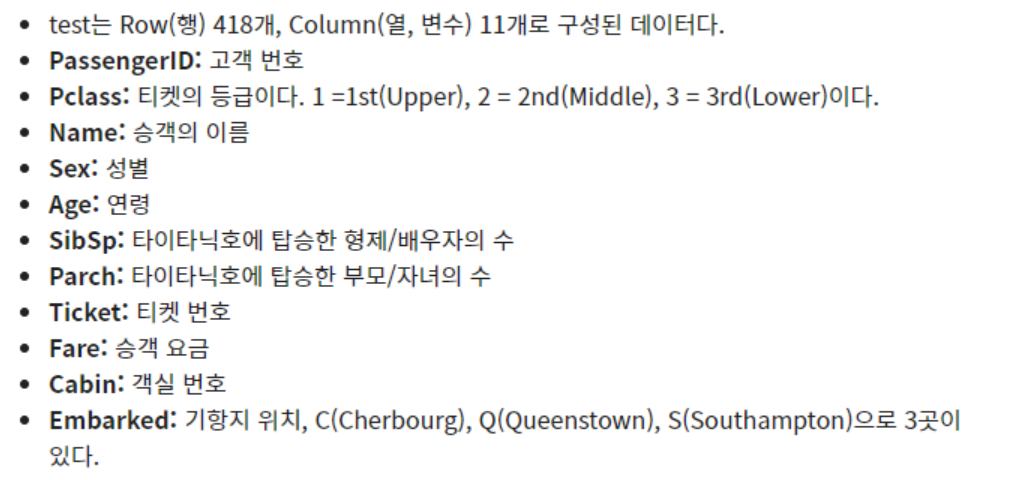

In [5]:
# train 데이터 정보 확인
train_data.info()
# 결측치 -> 있음 (Age, Cabin, Embarked)
# 데이터 타입 -> 문자열데이터 확인

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
# test 데이터 정보 확인
test_data.info()
# 결측치 -> 있음 (Age, Cabin, Fare)
# 데이터 타입 -> 문자열데이터 확인

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


### 결측치가 있는 컬럼 결측치 채워주기!
- train
    - Age, Cabin, Embarked
- test
    - Age, Cbin, Fare
- 결측치를 단순 기술통계량으로 채우지않고 각 특성간의 관계를 찾아서 결측치를 채워보자~

- train -> Age 결측치 채우기

In [7]:
# Age 기술통계량 확인
train_data['Age'].describe()
# 총 714개 데이터
# 평균 29
# 중앙값 28
# 전체적인 나이가 앞쪽에 몰려있는 형태

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [8]:
# 상관관계확인
train_data.corr(numeric_only = True)

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [9]:
# 나이데이터와 상관관계가 높은 Pclass 컬럼을 활용하여 결측치를 채워보자
# 생존에 영향을 많이 미쳤던 성별데이터도 활용하자
# 피벗테이블 : 컬럼들의 요약된 정보를 출력
pt1 = train_data.pivot_table(values='Age',
                             index=['Pclass','Sex'],
                             aggfunc='mean')
pt1
# Pclass와 Sex에 따른 나이 평균값을 확인

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [10]:
# 다중인덱싱
# df명.loc[(행1, 행2),열]
pt1.loc[(1,'female'), 'Age']

34.61176470588235

In [11]:
# 2등급이면서 남자의 나이
pt1.loc[(2,'male'), 'Age']

30.74070707070707

In [12]:
# 3등급이면서 여자의 나이
pt1.loc[(3,'female'), 'Age']

21.75

In [13]:
# 나이 결측치를 채우는 함수 정의하기
def fill_age(data):
    if pd.isna(data['Age']):
        return pt1.loc[(data['Pclass'], data['Sex']), 'Age']
        # 비어있는 사람의 등급과 성별에 맞는 나이를 추출 
    else: # 나이가 있는 경우
        return data['Age'] # 원래 나이를 추출 

In [14]:
# apply 함수를 사용하여 DataFrame에 fill_age 함수를 적용
# df.apply(함수명, 축설정)
train_data['Age'] = train_data.apply(fill_age, axis  = 1).astype('int64') # Age 컬럼에 적용할것! 

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


In [16]:
# 나이데이터와 상관관계가 높은 Pclass 컬럼을 활용하여 결측치를 채워보자
# 생존에 영향을 많이 미쳤던 성별데이터도 활용하자
# 피벗테이블 : 컬럼들의 요약된 정보를 출력
pt2 = test_data.pivot_table(values='Age',
                index=['Pclass','Sex'],
                 aggfunc='mean')
pt2
# Pclass와 Sex에 따른 나이 평균값을 확인

Age
Pclass Sex              
1      female  41.333333
       male    40.520000
2      female  24.376552
       male    30.940678
3      female  23.073400
       male    24.525104

In [17]:
# apply 함수를 사용하여 DataFrame에 fill_age 함수를 적용
# df.apply(함수명, 축설정)
test_data['Age'] = test_data.apply(fill_age, axis  = 1).astype('int64')

In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


In [19]:
train_data['Embarked'].value_counts()
# 'S' 항구에서 탑승한 승객이 가장 많은 것을 확인
# Embarked의 결측치는 단 2개
# 가장 많이 탑승한 'S'항구로 결측치를 채워보자!
# 데이터가 많을수록 한 두개의 데이터는 큰영향을 미치지 않음

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [20]:
train_data['Embarked'] = train_data['Embarked'].fillna('S')

In [21]:
train_data.info()
# Embarked 컬럼 889개 -> 891개 채워진것을 확인

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


- test -> Fare 결측치 채우기
    - 결측치 한개

In [22]:
test_data['Fare'].describe()
# 평균 : 35, 중위값 : 14, 최댓값 : 512
# 데이터가 앞쪽에 많이 몰려있음을 확인
# 평균으로 채우기에는 512라는 값이 영향을 너무 많이 끼쳤음 (이상치일확률 높음)
# 평규능로 채우기에는 데이터의 신뢰성이 떨어짐

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [23]:
# 상관관계 확인
test_data.corr(numeric_only = True)

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.520540,0.001087,0.018721,-0.577147
Age,-0.520540,1.000000,-0.084936,-0.062898,0.348593
SibSp,0.001087,-0.084936,1.000000,0.306895,0.171539
Parch,0.018721,-0.062898,0.306895,1.000000,0.230046
Fare,-0.577147,0.348593,0.171539,0.230046,1.000000


In [24]:
# 상관관계가 높은 Pclass 와 Sex를 활용하여 결측치를 채워보자!
# 피봇테이블 만들어 보기! (Fare평균)
pt2 = test_data.pivot_table(values='Fare', index=['Pclass','Sex'], aggfunc='mean')

In [25]:
pt2

Fare
Pclass Sex               
1      female  115.591168
       male     75.586551
2      female   26.438750
       male     20.184654
3      female   13.735129
       male     11.826350

In [26]:
# Fare 요금값이 비어있는 사람 추출 
# 불리언 인덱싱 : 조건을 통해 조건값이 True인 값만 추출 
# 데이터[조건]
test_data[test_data['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60,0,0,3701,NaN,NaN,S


In [27]:
# Fare결측치 채우기(11.826350) -> Pclass 3등급이면서 Sex가 남자인 사람의 요금 
test_data['Fare'] = test_data['Fare'].fillna(11.826350)


In [28]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


 - train, test -> cabin 결측치 채우기 

In [29]:
# 결측치의 개수 확인 
train_data['Cabin'].isna().value_counts()
# 결측치의 개수 : 687개(비어있는값 : 687개)
# 있는값보다 비어있는 값이 훨씬 많은것을 확인 
# 해볼 수 있는 만큼 결측치를 채워보고 최후의 방법으로 삭제를 고민

Cabin
True     687
False    204
Name: count, dtype: int64

In [30]:
# 데이터 확인(중복되지않은 유일한 값 확인)
train_data['Cabin'].unique()
# 전체적으로 중복된 데이터가 적음(148개의 카테고리가 나옴)
# 이런경우 어떤식으로 결과를 추출하면 좋을지 생각
# 규칙찾기 -> 알파벳 데이터를 확인 모든 데이터가 알파벳을 가지고 있는것을 확인 
# 알파벳데이터에서 규칙을 찾아보자!


array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [31]:
# train, test 데이터 결측치에 임의의 문자인 'M'채워서 관계 확인 
train_data['Cabin'] = train_data['Cabin'].fillna('M')
test_data['Cabin'] = test_data['Cabin'].fillna('M')
# 임의의 문자로 채워주는 이유는?
# 있는 데이터보다 없는 데이터가 더 많기 때문에 없는 데이터들에서도 패턴을 찾기 위함
# 시각화를 통해서 규칙 찾아보기

In [32]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,M,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,M,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,M,S


In [33]:
# 알파벳만 추출(Cabin의 첫번째 문자열만 추출)
train_data['Deck'] = train_data['Cabin'].str[0]
test_data['Deck'] = test_data['Cabin'].str[0]

In [34]:
# Cabin컬럼 삭제 
train_data.drop('Cabin', axis = 1, inplace=True)
test_data.drop('Cabin', axis = 1, inplace=True)

In [35]:
# 시각화해서 확인
# Deck컬럼에서 'M'데이터가 어떤 패턴을 가지는지 확인
train_data['Deck'].value_counts()

Deck
M    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [36]:
# 각 알파벳에 따른 생존 여부 확인
# groupby : 그룹별로 데이터를 집계, 요약해주는 함수 (그룹으로 묶어서 인덱스 설정)
train_data[['Survived', 'Deck','Name']].groupby(['Deck','Survived']).count()

Name
Deck Survived      
A    0            8
     1            7
B    0           12
     1           35
C    0           24
     1           35
D    0            8
     1           25
E    0            8
     1           24
F    0            5
     1            8
G    0            2
     1            2
M    0          481
     1          206
T    0            1

<Axes: xlabel='Deck', ylabel='count'>

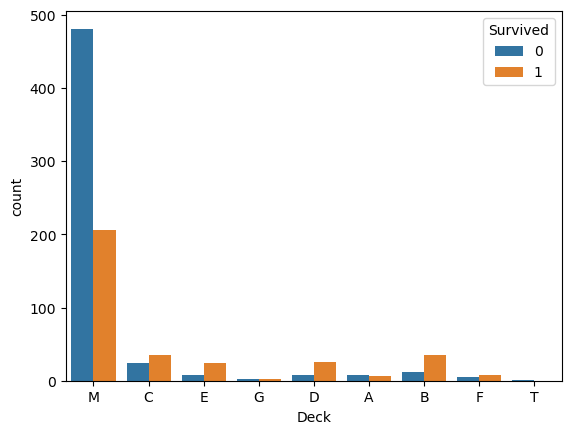

In [37]:
# 시각화 
# seaborn 라이브러리를 활용하여 Deck 시각화 
# pandas와 호환성이 좋음, 그래프의 성능이 높은 편 
sns.countplot(data = train_data,
             x = 'Deck', # X축으로 갈 데이터 작성 
             hue = 'Survived') # unique한 데이트만큼 차트가 생성 -> 범례

# M이라는 값을 가진 사람들이 죽을 확률이 높은것을 확인 
# Deck 컬럼을 분석에 사용해도 괜찮을 듯 ! 


In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Embarked  418 non-null    object 
 9   Deck      418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


### 특성공학 -> 새로운 특성을 추출
- Parch : parent, children 함께 탑승한 부모, 자식의 수 
- SibSp : 함께 탑승한 형제 , 자매의 수
- 결국 위 두개의 데이터는 비슷한 결을 가지고 있음(함께 탑승한 구성원)
- 하나로 합쳐서 가족의 숫자라는 컬럼으로 만들어주기!

In [41]:
# train, test 둘다 적용
train_data['Family_Size'] = train_data['Parch'] + train_data['SibSp']+1 # 자기자신의 수 더해주기
test_data['Family_Size'] = test_data['Parch'] + test_data['SibSp']+1  # 자기자신의 수 더해주기 

<Axes: xlabel='Family_Size', ylabel='count'>

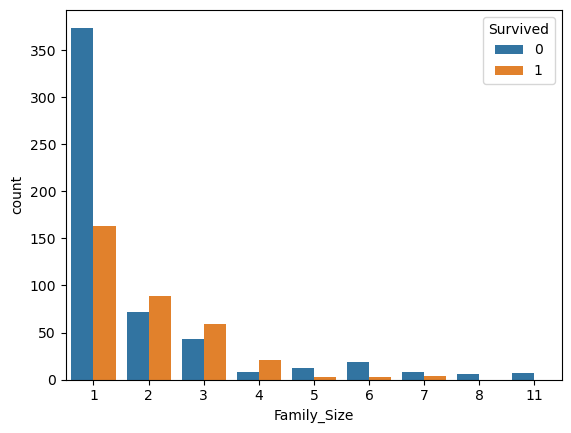

In [42]:
# 가족의 수에 따른 패턴을 찾기 위해 시각화
sns.countplot(data = train_data,
             x = 'Family_Size',
             hue = 'Survived')

# 패턴확인
# 1명: 죽을 확률이 높은것 확인
# 2명~4명 : 살 확률이 높음
# 5명 이상 : 죽은 비율이 높음 
# 범주의 크기를 줄여주는 것이 학습에 도움이 된다.!
# bining : 사소한 관찰의 오류를 줄여준다. 

In [43]:
# 카테고리화 (cut함수사용)
b = [0, 1, 4, 11] # 범주의 범위(1~1, 2~4, 5~11 3개의 그룹)
l = ['Alon', 'Small', 'Large'] # 각 범주별로 이름을 설정
train_data['Family_Size'] = pd.cut(train_data['Family_Size'], bins = b, labels=l)
test_data['Family_Size'] = pd.cut(test_data['Family_Size'], bins = b, labels=l)

<Axes: xlabel='Family_Size', ylabel='count'>

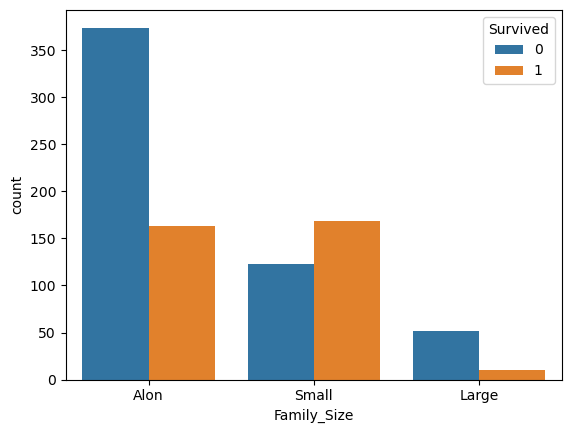

In [44]:
# 범주화 된 가족의 수를 시각화
# 가족의 단위별로 생존패턴 확인 
sns.countplot(data = train_data,
             x = 'Family_Size', # X축으로 갈 데이터 작성 
             hue = 'Survived') # unique한 데이트만큼 차트가 생성 -> 범례

### text 데이터 다루기 (Name컬럼)
 - 이름데이터는 중복된 데이터가 없음
 - 원핫인코딩을 할 경우 891개의 컬럼이 추가 -> 의미가 없음
 - 컬럼 삭제 여부 판단 

In [45]:
train_data['Name']
# 호칭을 활용한 패턴 파악 

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [46]:
# 첫번째 사람 불러와서 확인 
print(train_data['Name'][1])
print(train_data['Name'][2])
print(train_data['Name'][3])

Braund, Mr. Owen Harris
Cumings, Mrs. John Bradley (Florence Briggs Thayer)
Heikkinen, Miss. Laina


In [47]:
# 쉼표를 기준으로 나누기 -> 나눈 후 결과는 리스트 형태로 출력
train_data['Name'][1].split(',')

['Braund', ' Mr. Owen Harris']

In [48]:
# 나뉜거에서 뒷부분만 추출
train_data['Name'][1].split(',')[1]

' Mr. Owen Harris'

In [49]:
# 다시한번 .을 기준으로 나누기 
train_data['Name'][1].split(',')[1].split('.')

[' Mr', ' Owen Harris']

In [50]:
# 나눈 데이터에서 앞부분만 추출
train_data['Name'][1].split(',')[1].split('.')[0]

' Mr'

In [51]:
# 공백을 없애주는 함수 .strip()
train_data['Name'][1].split(',')[1].split('.')[0].strip()

'Mr'

In [52]:
# 위 작업을 함수화해서 DataFrame에 적용
def split_name (data):
    return data.split(',')[1].split('.')[0].strip()
# 호칭을 추출해 준다. 


In [53]:
# apply 함수를 통해서 적용 
train_data['Title'] = train_data['Name'].apply(split_name)
test_data['Title'] = test_data['Name'].apply(split_name)

In [54]:
train_data['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [55]:
test_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

(0.0, 10.0)

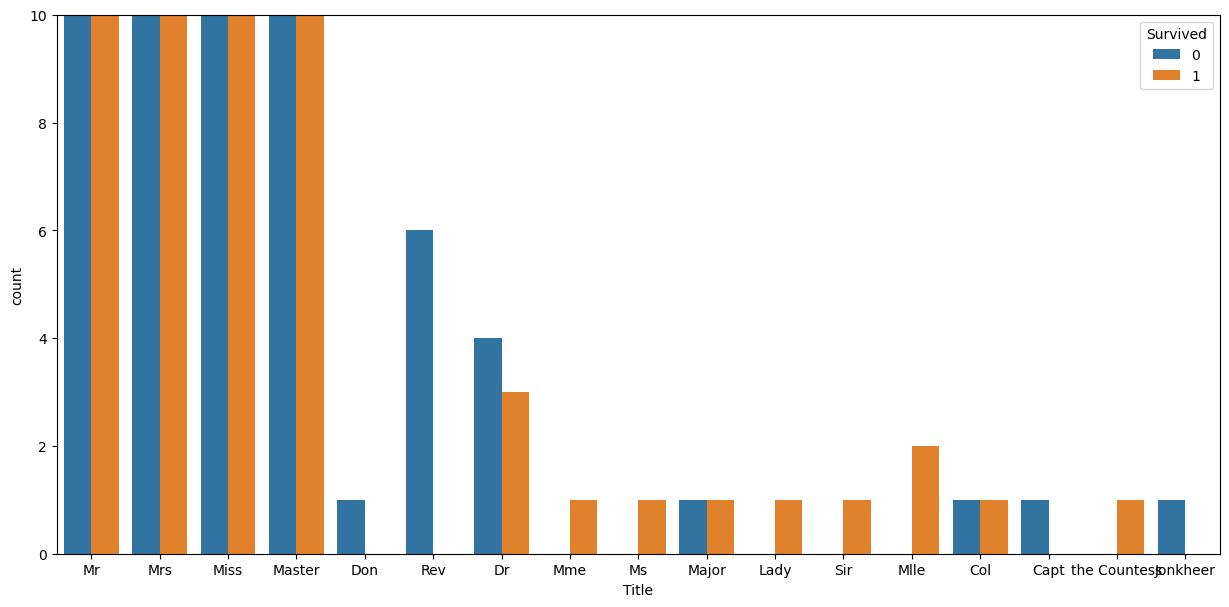

In [56]:
# 호칭별 생존여부 확인을 위한 그래프 그려보기

plt.figure(figsize = (15,7))
sns.countplot(data = train_data,
             x = 'Title', # X축으로 갈 데이터 작성 
             hue = 'Survived') # unique한 데이트만큼 차트가 생성 -> 범례
plt.ylim(0,10)


# Rev(목사님):'목사님의 사망률 100%'

- 개수가 많은 특징있는 데이터를 제외하고 나머지는 하나의 그룹(Other)묶어 주기!

In [57]:
train_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [58]:
# 호칭의 unique한 값들만을 가져와서 map()
title = ['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Don',  'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer']
len(title)

17

In [59]:
# 전환할 호칭들이 담긴 리스트

convert_title = ['Mr', 'Mrs', 'Miss', 'Master', 'Rev'] + ['Other'] * 12
convert_title

['Mr',
 'Mrs',
 'Miss',
 'Master',
 'Rev',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other']

In [60]:
# 실제데이터와 전환할 데이터 딕셔너리 화 -> 왜? map()함수 쓰기 위해서
title_dic = dict(zip(title,convert_title))

In [61]:
# map() 함수를 사용하여 key값에 해당하는 데이터를 value값으로 변환 
train_data['Title'] = train_data['Title'].map(title_dic)
train_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other', 'Rev'], dtype=object)

In [62]:
# test 데이터도 변경 
test_data['Title'].unique()
# train에는 없는데 test 에만 있는 데이터 -> Dona

title_dic['Dona'] = 'Other'
title_dic

{'Mr': 'Mr',
 'Mrs': 'Mrs',
 'Miss': 'Miss',
 'Master': 'Master',
 'Rev': 'Rev',
 'Don': 'Other',
 'Dr': 'Other',
 'Mme': 'Other',
 'Ms': 'Other',
 'Major': 'Other',
 'Lady': 'Other',
 'Sir': 'Other',
 'Mlle': 'Other',
 'Col': 'Other',
 'Capt': 'Other',
 'the Countess': 'Other',
 'Jonkheer': 'Other',
 'Dona': 'Other'}

In [63]:
test_data['Title'] = test_data['Title'].map(title_dic)

In [64]:
test_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other', 'Rev'], dtype=object)

In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Name         891 non-null    object  
 3   Sex          891 non-null    object  
 4   Age          891 non-null    int64   
 5   SibSp        891 non-null    int64   
 6   Parch        891 non-null    int64   
 7   Ticket       891 non-null    object  
 8   Fare         891 non-null    float64 
 9   Embarked     891 non-null    object  
 10  Deck         891 non-null    object  
 11  Family_Size  891 non-null    category
 12  Title        891 non-null    object  
dtypes: category(1), float64(1), int64(5), object(6)
memory usage: 123.8+ KB


In [66]:
train_data['Ticket'].unique()
# 큰 의미가 없어 보임 -> Ticket 컬럼 삭제 

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

- 불필요한 컬럼 삭제
    - Name
    - SibSp
    - Parch
    - Ticket

In [67]:
train_data.drop(['Name','SibSp','Parch','Ticket'], axis = 1, inplace = True)
test_data.drop(['Name','SibSp','Parch','Ticket'], axis = 1, inplace = True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Sex          891 non-null    object  
 3   Age          891 non-null    int64   
 4   Fare         891 non-null    float64 
 5   Embarked     891 non-null    object  
 6   Deck         891 non-null    object  
 7   Family_Size  891 non-null    category
 8   Title        891 non-null    object  
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 95.9+ KB


In [68]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Sex          891 non-null    object  
 3   Age          891 non-null    int64   
 4   Fare         891 non-null    float64 
 5   Embarked     891 non-null    object  
 6   Deck         891 non-null    object  
 7   Family_Size  891 non-null    category
 8   Title        891 non-null    object  
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 95.9+ KB


In [69]:
test_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Pclass       418 non-null    int64   
 1   Sex          418 non-null    object  
 2   Age          418 non-null    int64   
 3   Fare         418 non-null    float64 
 4   Embarked     418 non-null    object  
 5   Deck         418 non-null    object  
 6   Family_Size  418 non-null    category
 7   Title        418 non-null    object  
dtypes: category(1), float64(1), int64(2), object(4)
memory usage: 26.7+ KB


### EDA(탐색적 데이터 분석)
 - 데이터가 가지고 있는 단서들을 찾아보는 시간
 - 데이터가 가지고 있는 값들을 시각화 시켜 단서들을 한눈에 알아보게 만들자!

In [70]:
train_data.info()
# int64 정수형
# float64 실수형
# 

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Sex          891 non-null    object  
 3   Age          891 non-null    int64   
 4   Fare         891 non-null    float64 
 5   Embarked     891 non-null    object  
 6   Deck         891 non-null    object  
 7   Family_Size  891 non-null    category
 8   Title        891 non-null    object  
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 95.9+ KB


** 범주형 데이터 시각화 해보기

<Axes: xlabel='Pclass', ylabel='count'>

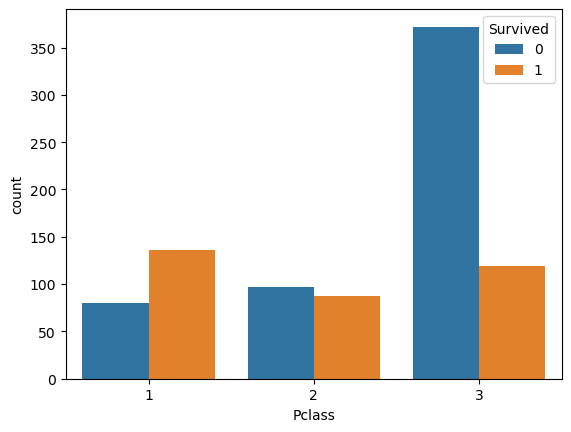

In [71]:
#1. pclass와 survived값의 시각화를 진행해보자!
# Pclass가 뭐길래? Pclass에 따라 사람이 어떻게 죽었나 살았나 시각화!
sns.countplot(data = train_data,
            x='Pclass',
             hue='Survived')

In [72]:
# X축에 1, 2, 3 등급이 들어감.


- 3등급의 사람이 많이 죽었구나!

<Axes: xlabel='Deck', ylabel='count'>

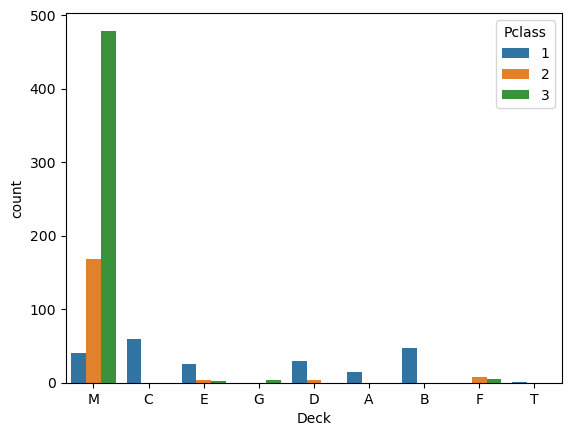

In [73]:
#2. pclass와 Deck+값의 시각화를 진행해보자!
# Pclass가 뭐길래? Pclass에 따라 사람이 어떻게 죽었나 살았나 시각화!
sns.countplot(data = train_data,
            x='Deck',
             hue='Pclass')

# M이었던사람들은 많이 죽었다. 

- 3등급 사람들이 M이라는 곳에 많이 분포되어 있구나

<Axes: xlabel='Pclass', ylabel='count'>

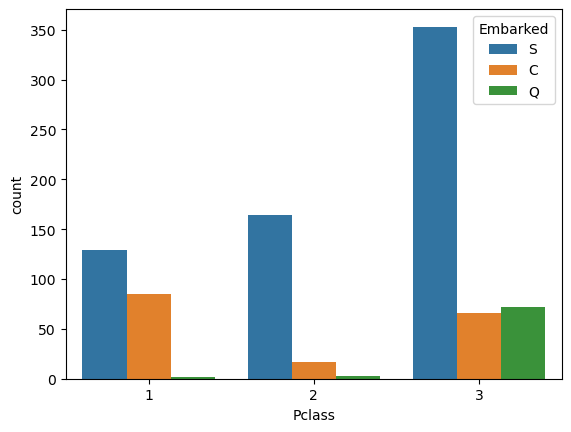

In [74]:
# 3. pclass와 Embarked값의 시각화를 진행해보자!

sns.countplot(data = train_data,
            x='Pclass',
             hue='Embarked')

 - 사우스햄튼에서 탄 사람중에 3등급이 많았다. 
 - 전체적으로 사우스햄튼 승선객이 많았다. 

<Axes: xlabel='Embarked', ylabel='count'>

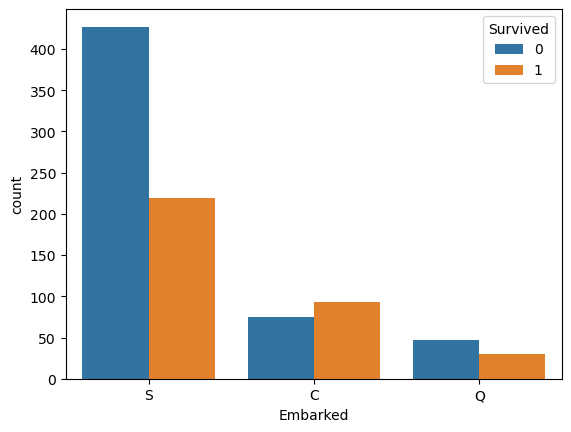

In [75]:
# 4. Embarked와 Survived값의 시각화를 진행해보자!

sns.countplot(data = train_data,
            x='Embarked',
             hue='Survived')

# 승선지에 따른 생존 유무를 살펴보쟈!

- 사우스햄튼 승객이 많이 죽었다.
- 이유) 사우스햄튼에서 탄 승객들이 가장 많고, 좋지않은 객실에 배정됬을 가능성이 있다.

<Axes: xlabel='Sex', ylabel='count'>

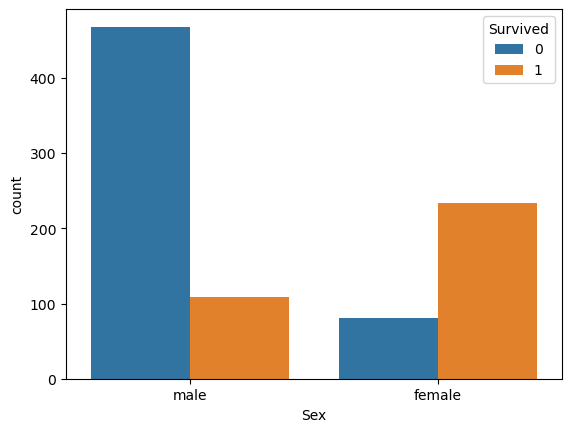

In [76]:
# 4. Sex와 Survived값의 시각화를 진행해보자!

sns.countplot(data = train_data,
            x='Sex',
             hue='Survived')

 - 남자가 많이 죽었고, 여자가 많이 살았다.
 - 노블리스오블리주

수치형 데이터 시각화

In [77]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Sex          891 non-null    object  
 3   Age          891 non-null    int64   
 4   Fare         891 non-null    float64 
 5   Embarked     891 non-null    object  
 6   Deck         891 non-null    object  
 7   Family_Size  891 non-null    category
 8   Title        891 non-null    object  
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 95.9+ KB


<Axes: xlabel='Age', ylabel='count'>

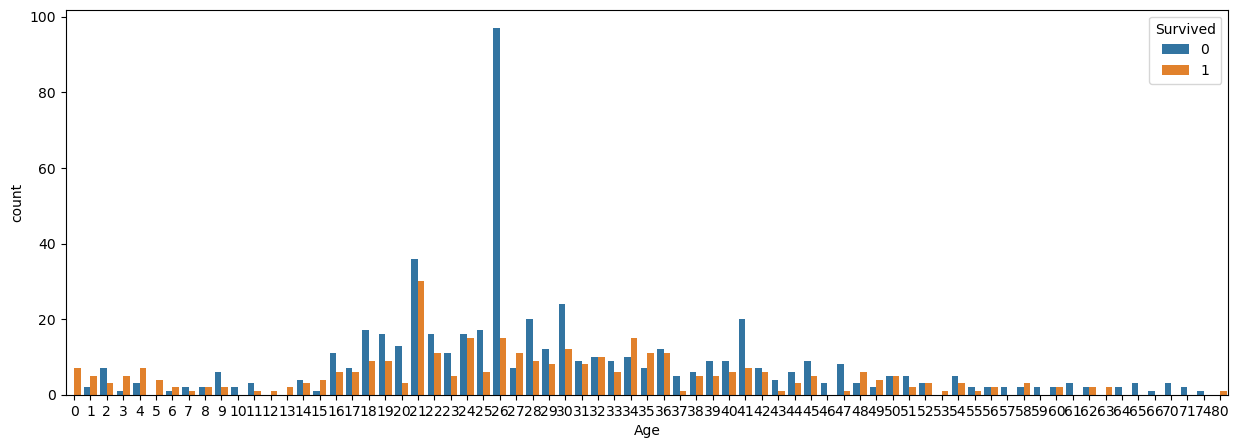

In [78]:
# 1. age와 Survived값의 시각화를 진행해보자!

plt.figure(figsize = (15,5))
sns.countplot(data = train_data,
            x='Age',
             hue='Survived')

 - 연속된 수지형의 데이터를 막대 그래프를 이용해서 출력할 경우 범주가 많아져서 그래프를 해석하기 어려워진다.
 - 막대그래프는 범주형 데이터의 수를 셀 때 용이 하다.
 - 연속 된 수치형 그래프를 잘 표현하는 기능을 사용해보자.

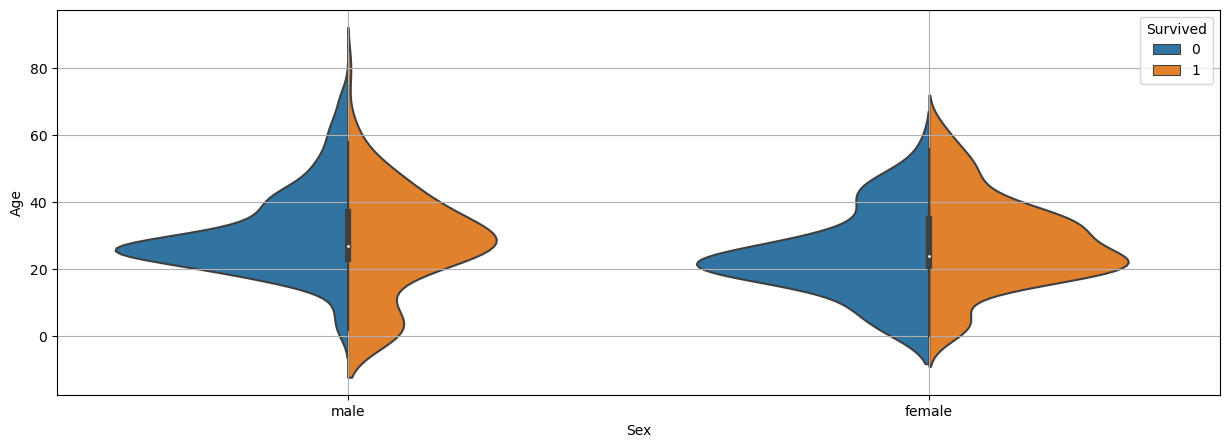

In [79]:
# 1. 나이 / 성별 , 생존 유무를 두고 바이올린 플롯을 그려보자
plt.figure(figsize=(15,5)) # 그래프의 사이즈 조절 
sns.violinplot(data = train_data, # 정보를 가져 올 데이터 프레임 명 
                x = 'Sex', # X축에 들어갈 데이터
                y = 'Age', # y축에 들어갈 데이터 
                hue = 'Survived', # Hue라는 데이터는 이 데이터를 카운터 해주세요(카운터를 세주는 기준)
               # ㄴ hue x축에 성별을 넣어주시고 y축에 나이를 넣어서 수를 세주세요 라는 의미 
                split= True
              ) 
plt.grid()
# 바이올린 플롯은 연속 된 수치형을 표시할 때 용이한 그래프다.
# 숫자가 클수록 두껍게 표시 / 숫자가 작을수록 가늘게 표시한다. 

 - 20대에서 40대의 사람들이 많이 죽었다. 
 - 성별부분에서는 20대~40대 사이의 여자들이 상대적으로 생존율이 높다. 
 - 남자 아이들의 생존율이 더 높다.
 - 시대적 배경

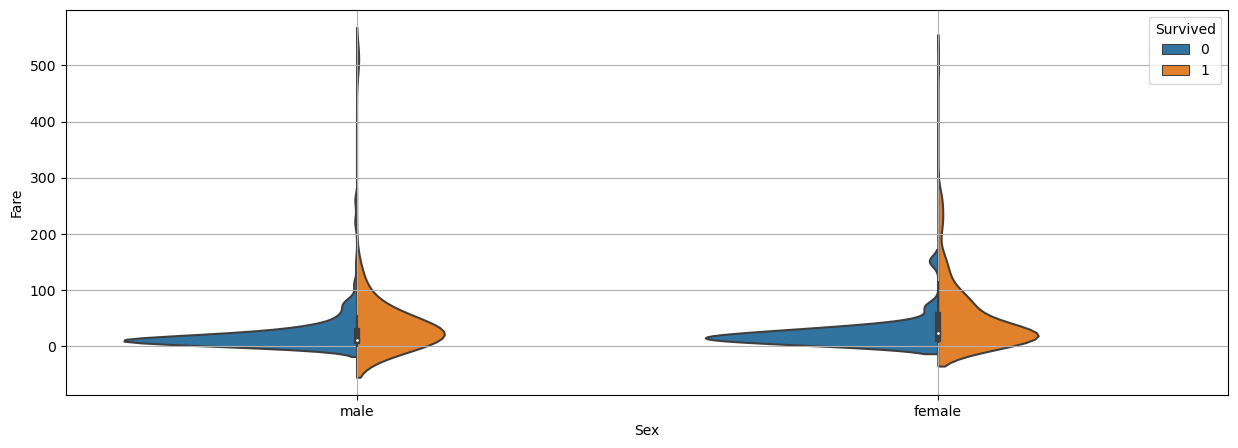

In [80]:
# 1. 나이 / 성별 , 생존 유무를 두고 바이올린 플롯을 그려보자
plt.figure(figsize=(15,5)) # 그래프의 사이즈 조절 
sns.violinplot(data = train_data, # 정보를 가져 올 데이터 프레임 명 
                x = 'Sex', # X축에 들어갈 데이터
                y = 'Fare', # y축에 들어갈 데이터 
                hue = 'Survived', # Hue라는 데이터는 이 데이터를 카운터 해주세요(카운터를 세주는 기준)
               # ㄴ hue x축에 성별을 넣어주시고 y축에 나이를 넣어서 수를 세주세요 라는 의미 
                split= True
              ) 
plt.grid()

 - 돈을 적게낸 탑승객들이 많이 죽었다.
 - 돈을 많이낸 사람들이 살았구나~
 - 돈을 많이 벌어야 한다!.....?

### 모델링(가공, 선택, 학습, 평가)

In [81]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Sex          891 non-null    object  
 3   Age          891 non-null    int64   
 4   Fare         891 non-null    float64 
 5   Embarked     891 non-null    object  
 6   Deck         891 non-null    object  
 7   Family_Size  891 non-null    category
 8   Title        891 non-null    object  
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 95.9+ KB


In [82]:
# 데이터분할이 안되어 있음
# 데이터 분할 (3가지로 분리)
# 3가지인 이유? 
X_train = train_data.drop('Survived', axis=1) # 훈련용 문제 데이터 -> 무슨 컬럼만 없어지면 될까? 
# X_train = train.loc[ : , 'Pclass':'Title']
# X_train = train.iloc[ : , '1': ]
X_test = test_data # 평가용 문제 데이터 -> test데이터 확인해볼 것 
y_train = train_data['Survived'] # 훈련용 정답 데이터 -> 우리가 예측하고자 하는 정답 : Survived 

In [83]:
# 중간 체크 포인트 - 데이터의 형태가 바꼈다!
# 어떤 형태인지 중간점검 해보자. 
print(X_train.shape, X_test.shape, y_train.shape)

(891, 8) (418, 8) (891,)


In [84]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Sex          891 non-null    object  
 3   Age          891 non-null    int64   
 4   Fare         891 non-null    float64 
 5   Embarked     891 non-null    object  
 6   Deck         891 non-null    object  
 7   Family_Size  891 non-null    category
 8   Title        891 non-null    object  
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 95.9+ KB


- 머신러닝의 작동원리는 연산을 통해서 진행하는데 문자는 연산이 되지 않기 때문에 숫자형으로 바꿔줘야한다.
- 인코딩으로 수치화 시켜줘야 함.

# 인코딩

### 범주형 -> 수치형
### 원핫인코딩 (우선순위가 없음)
 - 숫자라는 개념은 기본적으로 크기를 가지고 있다.
 - 데이터가 있다/없다 라고만 판단할때.
 - 이진법으로 바꿔주는 형태 (0/1, True/False)
 
### 라벨인코딩(레이블인코딩) (우선순위가 있음)
 - 순차적으로 0, 1, 2, 3, 4 연속된 숫자를 이용하고 있다. 
 - 잘 쓰지 않는다. 
 - 회귀에서는 라벨인코딩 절대 쓰지 않는다.
 - 라벨인코딩을 사용할때는 정답을 수치화 시킬 때 
 


- 머신러닝에서 연산을 통해 예측할 수 있도록 인코딩 작업을 진행하자.
- 원핫 인코딩을 이용하자!
- 훈련데이터와 평가데이터 인코딩은 똑같은 방법으로 진행해야 한다.

In [85]:
# 원핫인코딩 or 더미변수화 
X_train_oh = pd.get_dummies(X_train, dtype='int64')
X_test_oh = pd.get_dummies(X_test, dtype='int64')
# 훈련데이터와 평가데이터 같은 인코딩을 사용해야 한다. 

- 주의점 
    - 훈련데이터와 평가데이터 -> 똑같은 인코딩 방법 적용
    - 데이터 전처리시 훈련데이터에 전처리한 방식을 평가 데이터에서도 똑같이 적용할 것.

In [86]:
X_train_oh.shape, X_test_oh.shape

((891, 26), (418, 25))

In [87]:
# 원 핫 인코딩 후 훈련용 문제 데이터에 1개의 컬럼이 더 늘었다. 
# 무슨 컬럼이 더 늘었는지 확인해보자
X_train_oh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pclass             891 non-null    int64  
 1   Age                891 non-null    int64  
 2   Fare               891 non-null    float64
 3   Sex_female         891 non-null    int64  
 4   Sex_male           891 non-null    int64  
 5   Embarked_C         891 non-null    int64  
 6   Embarked_Q         891 non-null    int64  
 7   Embarked_S         891 non-null    int64  
 8   Deck_A             891 non-null    int64  
 9   Deck_B             891 non-null    int64  
 10  Deck_C             891 non-null    int64  
 11  Deck_D             891 non-null    int64  
 12  Deck_E             891 non-null    int64  
 13  Deck_F             891 non-null    int64  
 14  Deck_G             891 non-null    int64  
 15  Deck_M             891 non-null    int64  
 16  Deck_T             891 non-null

In [88]:
X_test_oh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pclass             418 non-null    int64  
 1   Age                418 non-null    int64  
 2   Fare               418 non-null    float64
 3   Sex_female         418 non-null    int64  
 4   Sex_male           418 non-null    int64  
 5   Embarked_C         418 non-null    int64  
 6   Embarked_Q         418 non-null    int64  
 7   Embarked_S         418 non-null    int64  
 8   Deck_A             418 non-null    int64  
 9   Deck_B             418 non-null    int64  
 10  Deck_C             418 non-null    int64  
 11  Deck_D             418 non-null    int64  
 12  Deck_E             418 non-null    int64  
 13  Deck_F             418 non-null    int64  
 14  Deck_G             418 non-null    int64  
 15  Deck_M             418 non-null    int64  
 16  Family_Size_Alon   418 non-n

In [89]:
# train 데이터에만 있는 Deck_T라는 컬럼을 test 데이터에도 추가하자
X_test_oh['Deck_T'] = 0

In [90]:
X_test_oh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pclass             418 non-null    int64  
 1   Age                418 non-null    int64  
 2   Fare               418 non-null    float64
 3   Sex_female         418 non-null    int64  
 4   Sex_male           418 non-null    int64  
 5   Embarked_C         418 non-null    int64  
 6   Embarked_Q         418 non-null    int64  
 7   Embarked_S         418 non-null    int64  
 8   Deck_A             418 non-null    int64  
 9   Deck_B             418 non-null    int64  
 10  Deck_C             418 non-null    int64  
 11  Deck_D             418 non-null    int64  
 12  Deck_E             418 non-null    int64  
 13  Deck_F             418 non-null    int64  
 14  Deck_G             418 non-null    int64  
 15  Deck_M             418 non-null    int64  
 16  Family_Size_Alon   418 non-n

In [91]:
X_train_oh.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T', 'Family_Size_Alon',
       'Family_Size_Small', 'Family_Size_Large', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Other', 'Title_Rev'],
      dtype='object')

In [92]:
# 원할한 학습을 위해서 컬럼의 순서를 맞춰주자
# 사람이 볼 때는 순서상 미스가 사소한 문제지만 기계학습에선 큰 차이를 불러 올 수 있다.
X_test_oh = X_test_oh[X_train_oh.columns]

In [93]:
X_test_oh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pclass             418 non-null    int64  
 1   Age                418 non-null    int64  
 2   Fare               418 non-null    float64
 3   Sex_female         418 non-null    int64  
 4   Sex_male           418 non-null    int64  
 5   Embarked_C         418 non-null    int64  
 6   Embarked_Q         418 non-null    int64  
 7   Embarked_S         418 non-null    int64  
 8   Deck_A             418 non-null    int64  
 9   Deck_B             418 non-null    int64  
 10  Deck_C             418 non-null    int64  
 11  Deck_D             418 non-null    int64  
 12  Deck_E             418 non-null    int64  
 13  Deck_F             418 non-null    int64  
 14  Deck_G             418 non-null    int64  
 15  Deck_M             418 non-null    int64  
 16  Deck_T             418 non-n

In [94]:
set(X_train_oh) - set(X_test_oh)

set()

In [95]:
# 모델 선택 및 사용
# 모델 import
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [96]:
# 모델 객체 생성 (기본 모델 사용)
knn_model = KNeighborsClassifier()

In [97]:
# 모델 학습
knn_model.fit(X_train_oh, y_train)

KNeighborsClassifier()

In [98]:
# 모델 예측
pre = knn_model.predict(X_test_oh.values)

C:\Users\smhrd\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [99]:
pre

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [100]:
# 경고창 제거
import warnings
warnings.filterwarnings('ignore')

In [101]:
# 교차검증 점수 확인
rs = cross_val_score(knn_model, X_train_oh.values, y_train, cv=5)

In [102]:
print(rs)
print(rs.mean())

[0.67597765 0.69101124 0.71348315 0.73033708 0.74157303]
0.7104764296026616


In [103]:
# 답안지 파일 가져오기

In [104]:
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [105]:
# 기존 답 덮어쓰기
result['Survived'] = pre

In [106]:
result

,Survived
PassengerId,
892,0
893,0
894,0
895,1
896,0
...,...
1305,0
1306,1
1307,0


In [107]:
# 파일 저장
result.to_csv('data/Knn_submit_01.csv', index=True)

In [108]:
# knn 모델 하이퍼 파라미터 조절 후 파일 생성
# 모델 객체 불러오기(n_neighbors = 1~20)
knn_model2 = KNeighborsClassifier(n_neighbors = 10)

# 모델 학습
knn_model2.fit(X_train_oh, y_train)

# 모델 예측
pre = knn_model2.predict(X_test_oh.values)
pre

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [109]:
# 교차검증 점수 확인
rs = cross_val_score(knn_model2, X_train_oh.values, y_train, cv=5)

print(rs)
print(rs.mean())

[0.65363128 0.71910112 0.71348315 0.7247191  0.7247191 ]
0.7071307513652627


In [110]:
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [111]:
# 기존 답 덮어쓰기
result['Survived'] = pre
result

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


In [112]:
# 파일 저장
result.to_csv('data/Knn_submit_02.csv', index=True)

### 현재  knn 모델 60% 중반 성능을 보인다                                                                                                                                                                       

In [113]:
# 모델 객체 생성
tree_model1 = DecisionTreeClassifier()

In [114]:
# 모델 학습
tree_model1.fit(X_train_oh, y_train)

DecisionTreeClassifier()

In [115]:
# 모델 교차검증
rs = cross_val_score(tree_model1, X_train_oh, y_train, cv = 5)
print(rs)
print(rs.mean())

[0.79329609 0.78651685 0.84269663 0.7752809  0.78651685]
0.7968614650681063


In [116]:
# 모델 예측
pre = tree_model1.predict(X_test_oh)

In [117]:
# 답안지 작성
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result['Survived'] = pre
result

,Survived
PassengerId,
892,0
893,0
894,1
895,1
896,1
...,...
1305,0
1306,1
1307,0


In [118]:
# 파일 저장
result.to_csv('data/tree_submit_01.csv', index=True)

In [119]:
# tree_model 하이퍼 파라미터 조절
# max_depth = 5
# 모델 객체 생성
tree_model2 = DecisionTreeClassifier(max_depth=5)
# 모델 학습
tree_model2.fit(X_train_oh, y_train)
# 모델 예측
pre = tree_model2.predict(X_test_oh)
# 답안지 작성
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result['Survived'] = pre
# 파일 저장
result.to_csv('data/tree_submit_02.csv', index=True)

- 상대적으로 tree 모델 성능이 잘 나온다
- knn 모델의 성능을 올려보자

### 데이터 스케일링
- 거리 기반의 knn모델의 성능을 끌어올리기 위해 데이터 스케일링 (깔끔하게 만들자) 지행

In [120]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [121]:
# StandardScaler 사용해보기
s_scale = StandardScaler()

In [122]:
# StandardScaler 학습
s_scale.fit(X_train_oh)

StandardScaler()

In [123]:
# 스케일링  적용
# transform
X_train_ss = s_scale.transform(X_train_oh)
X_test_ss = s_scale.transform(X_test_oh)

### 스케일링된 데이터를 가지고 KNN 모델 학습 및 예측 평가를 진행해보자

In [124]:
# 모델 객체 생성
knn_ss = KNeighborsClassifier()

In [125]:
# 모델 학습
knn_ss.fit(X_train_ss, y_train)

KNeighborsClassifier()

In [126]:
pre = knn_ss.predict(X_test_ss)

In [127]:
# 답안지 작성
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result['Survived'] = pre
# 파일 저장
result.to_csv('data/Knn_submit_03.csv', index=True)

In [128]:
# fit(학습) / fit_transform(학습 후 변환)
# 주의점) 같은 기준점을 학슴한 스케일러를 사용해야 한다.
# 훈련데이터에서는 fit_transform을 사용해도 되지만
# 평가데이터에서는 transform 함수만 사용한다.

In [129]:
# minmax scaler 사용해보기
m_scale = MinMaxScaler()
m_scale.fit(X_train_oh, y_train)
X_train_mm = m_scale.transform(X_train_oh)
X_test_mm = m_scale.transform(X_test_oh)

knn_mm = KNeighborsClassifier()
knn_mm.fit(X_train_mm, y_train)
pre = knn_mm.predict(X_test_mm)
# 답안지 작성
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result['Survived'] = pre
# 파일 저장
result.to_csv('data/Knn_submit_04.csv', index=True)

## RandomForest 사용해보기
- 배깅의 대표 모델
- 여러개의 결정 트리 모델을 이용해서 병렬적으로 학습/예측하는 방식
- 통계적인 방법 (다수결 / 확률의 평균)을 이용해서 과대적합 제어에 용이한 모델

In [130]:
from sklearn.ensemble import RandomForestClassifier

In [131]:
# 모델 객체 생성
rf_model1 = RandomForestClassifier()

In [132]:
# 모델 학습
rf_model1.fit(X_train_oh, y_train)

RandomForestClassifier()

In [133]:
pre = rf_model1.predict(X_test_oh)

In [134]:
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result['Survived'] = pre
result.to_csv('data/rf_submit_05.csv', index=True)

In [135]:
rf_model2 = RandomForestClassifier(n_estimators=500)
rf_model2.fit(X_train_oh, y_train)
pre = rf_model2.predict(X_test_oh)
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result['Survived'] = pre
result.to_csv('data/rf_submit_06.csv', index=True)

## Ada Boosting

In [136]:
from sklearn.ensemble import AdaBoostClassifier

In [137]:
ada_model1 = AdaBoostClassifier()

In [138]:
ada_model1.fit(X_train_oh, y_train)

AdaBoostClassifier()

In [139]:
pre = ada_model1.predict(X_test_oh)

In [140]:
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result['Survived'] = pre
result.to_csv('data/ada_submit_07.csv', index=True)

## Gradient Boost Model

In [141]:
from sklearn.ensemble import GradientBoostingClassifier

In [142]:
gb_model1 = GradientBoostingClassifier()
gb_model1.fit(X_train_oh, y_train)
pre = gb_model1.predict(X_test_oh)
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result['Survived'] = pre
result.to_csv('data/gb_submit_08.csv', index=True)

## XG Boost Model

In [143]:
# !pip install xgboost

In [144]:
# !pip install lightgbm

In [145]:
from xgboost import XGBClassifier

In [146]:
xgb_model1 = XGBClassifier(n_estimators = 100)

In [147]:
xgb_model1.fit(X_train_oh, y_train)
pre = xgb_model1.predict(X_test_oh)
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result['Survived'] = pre
result.to_csv('data/xgb_submit_09.csv', index=True)

In [148]:
from lightgbm import LGBMClassifier
lgb_model1 = LGBMClassifier(n_estimators = 100)
lgb_model1.fit(X_train_oh,y_train)
pre = lgb_model1.predict(X_test_oh)
result = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')
result['Survived'] = pre
result.to_csv('data/lgb_submit_10.csv', index=True)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288


### Grid Search 사용해보기
- 우리가 정해준 일정 범위 및 개수의 하이퍼 파라미터를 이용하여 가능한 조합식으로 교차검증 후 최고의 성능을 뽑아내는 하이퍼 파라미터 조합을 찾아주는 도구
- 이후 최고의 성능을 뽑아내는 하이퍼 파라미터 조합을 찾아주는 도구

In [155]:
# Random Forest 하이퍼 파라미터 찾아보기
# 모델 객체 생성
rf_model_grid = RandomForestClassifier(n_jobs=-1)

In [156]:
# grid_search 모델을 사용하기 위한 파라미터 목록 만들어주기
params = {
    'n_estimators' : [100, 300, 500],
    'max_depth' : [1,2,3,4,5],
    'min_samples_split' : [1,3,5,7,9] ,
    'min_samples_leaf' : range(1,6)
}

In [157]:
# grid_search 모델 불러오기
from sklearn.model_selection import GridSearchCV

In [158]:
# grid_search 모델 사용해보기
# grid = GridSearchCV(모델명, 하이퍼파라미터 목록, cv = 데이터 분할 숫자)
grid = GridSearchCV(rf_model_grid, params, cv = 5, n_jobs=-1)

In [159]:
grid.fit(X_train_oh, y_train) 

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': [1, 3, 5, 7, 9],
                         'n_estimators': [100, 300, 500]})

In [160]:
# grid_search 모델로 찾은 최고의 하이퍼 파라미터 조합 확인
grid.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [161]:
grid.best_score_

0.8338836231247253

In [163]:
rf_final = RandomForestClassifier(
    max_depth = 5,
    min_samples_leaf = 1,
    min_samples_split = 3,
    n_estimators = 100
)

In [164]:
rf_final

RandomForestClassifier(max_depth=5, min_samples_split=3)

In [165]:
rf_final2 = grid.best_estimator_
rf_final2

RandomForestClassifier(max_depth=5, min_samples_split=3, n_jobs=-1)

In [166]:
rf_final2.fit(X_train_oh, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=3, n_jobs=-1)

In [167]:
pre - rf_final2.predict(X_test_oh)
pre

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

<font color = 'red'>주의점<br>
    grid_search 모델 학습 중 (fit) value_error 발생시<br>
    --> 대부분의 확률로 하이퍼 파라미터 목록에 하이퍼 파라미터가 없거나
        오타가 났을 경우가 높음
</font>